In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add module tsmule to syspath
print("Current working dir:", os.getcwd())
sys.path.insert(0, '../../')

# Filter out all RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import logging 
logging.getLogger("stumpy").setLevel(logging.ERROR)


Current working dir: /Users/lamvo/Dev/research/ts-mule/demo/beijing_air_2_5


In [2]:
# Add module tsmule to system path
from tsmule.xai.lime import LimeTS
from tsmule.xai.evaluation import PerturbationAnalysis
from tsmule.sampling.segment import MatrixProfileSegmentation, SAXSegmentation
from tsmule.xai.viz import visualize_segmentation_mask


In [18]:
import dill 
from tensorflow import keras

data_dir = "."
cnn_model = keras.models.load_model(f'{data_dir}/beijing_air_2_5_cnn_model.h5')
with open(f'{data_dir}/beijing_air_2_5_test_data.dill', 'rb') as f:
    dataset_test = dill.load(f)

# Define a predict fn/model
def predict_fn(x):
    if len(x.shape) == 2:
        predictions = cnn_model.predict(x[np.newaxis]).ravel()
    if len(x.shape) == 3:
        predictions = cnn_model.predict(x).ravel()
    return predictions

In [19]:
# Get test set
X = dataset_test[0][:10]
Y = dataset_test[1][:10]


# Perturbation Analysis - overall

In [20]:
from sklearn import metrics

# Get relevance
explainer = LimeTS(n_samples=100)
relevance = [explainer.explain(x, predict_fn) for x in X]

# PerturbationAnalysis for Percentile 
#   replacement_method = 'zeros|global_mean|local_mean|inverse_max|inverse_mean'
pa = PerturbationAnalysis()
scores = pa.analysis_relevance(X, Y, relevance, 
                        predict_fn=predict_fn,
                        replace_method='zeros'  
                        eval_fn=metrics.mean_squared_error
                        percentile=90,
                        delta=0.1
                        )
scores

{'original': 0.6554225221193206,
 'percentile': 0.06203323741240281,
 'random': 0.22892935047346458}

# Deeper into perturbation analysis

In [48]:
# Get relevance of x
relevance = explainer.explain(x, predict_fn)

Text(0.5, 1.0, 'Randomize mask with delta=0.1 (round up)')

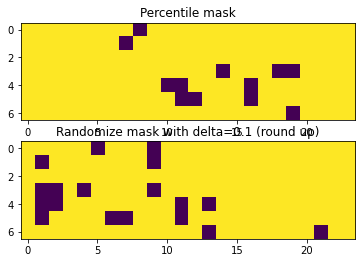

In [52]:
# Masking 90 percentile of relevance
mask_p90 = pa.mask_percentile(relevance, 90)
mask_random = pa.mask_randomize(relevance, 90, delta=0.1)

fig, ax = plt.subplots(2)
ax[0].imshow(mask_p90.T)
ax[0].set_title('Percentile mask')

ax[1].imshow(mask_random.T)
ax[1].set_title(f'Randomize mask with delta=0.1 (round up)')

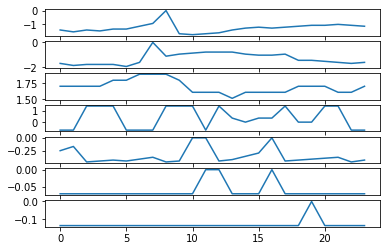

In [53]:
# Get a sample
x = X[0]
y = Y[0]

n_steps, features = x.shape

# Perturbe a sample based on percentile 90 of relevance
x_p90 = pa.perturb([x], [relevance])
x_p90 = next(x_p90)

fig = plt.figure()
for i in range(features):
    fig.add_subplot(features, 1, i+1)
    plt.plot(x_p90[:,i])

In [54]:
relevance = [explainer.explain(x, predict_fn) for x in X]

# Generate new perturbed samples
X_p90 = pa.perturb(X, relevance, percentile=90)

# Generator -> array
X_p90 = np.array(list(X_p90))

# Similarly to random
X_random = pa.perturb(X, relevance, shuffle=True, percentile=90)
X_random = np.array(list(X_random))

In [59]:
from sklearn import metrics

# Calculate score for Original
y_pred = predict_fn(X).ravel()
score_original = metrics.mean_squared_error(y_pred, Y)
score_original

0.6554225221193206

In [61]:
# Calculate score for Percentile 90
y_pred = predict_fn(X_p90).ravel()
score_p90 = metrics.mean_squared_error(y_pred, Y)
score_p90

0.2222669131046477

In [63]:
# Calculate score for Percentile 90
y_pred = predict_fn(X_random).ravel()
score_random = metrics.mean_squared_error(y_pred, Y)
score_random

0.13629906289879806